In [83]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn import linear_model, metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Exploratory Data Analysis (EDA)

## Data Preparation

In [85]:
file_path = "USvideos.csv"
usVideos = pd.read_csv(file_path)

In [86]:
# Check missing values
usVideos.isna().sum()

video_id                    0
trending_date               0
title                       0
channel_title               0
category_id                 0
publish_time                0
tags                        0
views                       0
likes                       0
dislikes                    0
comment_count               0
thumbnail_link              0
comments_disabled           0
ratings_disabled            0
video_error_or_removed      0
description               570
dtype: int64

In [87]:
usVideos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [92]:
# Feature Engineering
# Output
usVideos["net_likes"] = usVideos["likes"] - usVideos["dislikes"]

# Time
usVideos["trending_date"] = pd.to_datetime(usVideos["trending_date"], format="%y.%d.%m")
usVideos["publish_time"] = usVideos["publish_time"].apply(lambda row: row[:-11].replace("T", " "))
usVideos["publish_time"] = pd.to_datetime(usVideos["publish_time"], format="%Y-%m-%d %H")

usVideos["trending_minute_differences"] = usVideos["trending_date"] - usVideos["publish_time"]
usVideos["trending_minute_differences"] = usVideos["trending_minute_differences"].apply(lambda row: row.seconds / 60)

In [93]:
# Binary Feature
boolRows = ["comments_disabled", "ratings_disabled", "video_error_or_removed"]
for i in boolRows:
    usVideos[i] = usVideos[i].astype(int)

In [94]:
usVideos["title_len"] = usVideos["title"].apply(lambda row: len(row))

usVideos["channel_title_len"] = usVideos["channel_title"].apply(lambda row: len(row))

### Description

In [95]:
# concern1: description has many NA
na_des_rows = usVideos[usVideos['description'].isna()]

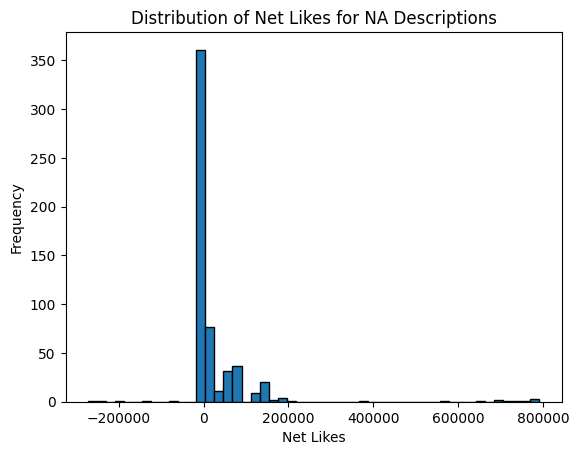

In [96]:
# 绘制net_likes的分布图
plt.hist(na_des_rows['net_likes'], bins=50, edgecolor='black')
plt.xlabel('Net Likes')
plt.ylabel('Frequency')
plt.title('Distribution of Net Likes for NA Descriptions')
plt.show()

In [97]:
np.median(na_des_rows['net_likes'])

893.5

Most people give no description would tend to give low net-likes

In [98]:
def des_length(description):
    if pd.isna(description):
        return 0
    else:
        return len(description)

# 应用这个函数到description列，并创建一个新列
usVideos['description_len'] = usVideos['description'].apply(des_length)

### Tags

In [99]:
# tilte includes [none], and many
usVideos['tags'].mode(0)

0    [none]
Name: tags, dtype: object

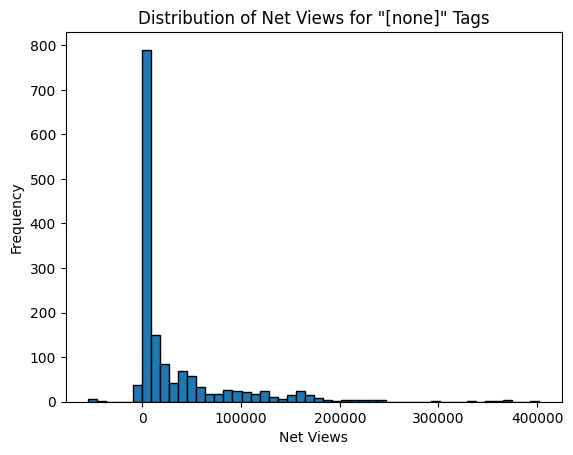

In [100]:
# 筛选出tags为"[none]"的行
none_tags_rows = usVideos[usVideos['tags'] == "[none]"]

# 绘制net_views的分布
plt.hist(none_tags_rows['net_likes'], bins=50, edgecolor='black')
plt.xlabel('Net Views')
plt.ylabel('Frequency')
plt.title('Distribution of Net Views for "[none]" Tags')
plt.show()

In [101]:
def calculate_tags_length(tags):
    if tags == "[none]":
        return 0
    else:
        return len(tags.split('|'))

# 应用这个函数到tags列，并创建一个新列
usVideos['tags_len'] = usVideos['tags'].apply(calculate_tags_length)

Clean the tags:

In [102]:
# 步骤1: 数据清洗 - 清洗tags列
usVideos['tags_cleaned'] = usVideos['tags'].str.split('|')

In [103]:
# 处理tags_cleaned列，去除每个标签中的双引号
usVideos['tags_cleaned'] = usVideos['tags_cleaned'].apply(lambda tags: [tag.replace('"', '') for tag in tags])

In [104]:
usVideos['tags_cleaned'][2]

['racist superman',
 'rudy',
 'mancuso',
 'king',
 'bach',
 'racist',
 'superman',
 'love',
 'rudy mancuso poo bear black white official music video',
 'iphone x by pineapple',
 'lelepons',
 'hannahstocking',
 'rudymancuso',
 'inanna',
 'anwar',
 'sarkis',
 'shots',
 'shotsstudios',
 'alesso',
 'anitta',
 'brazil',
 "Getting My Driver's License ",
 ' Lele Pons']

### Catagory Id

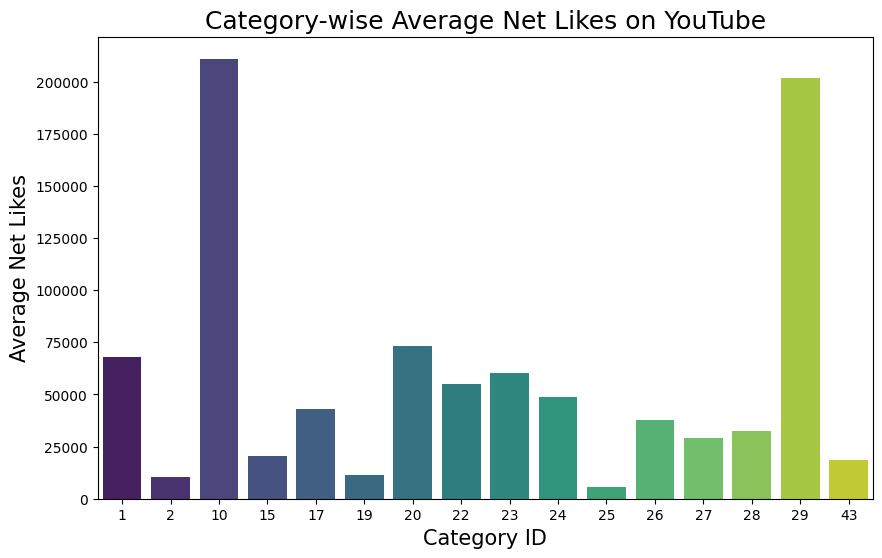

In [105]:
# 对数据按照category_id进行分组，并计算每组的net_likes平均值
grouped_data = usVideos.groupby('category_id')['net_likes'].mean().reset_index()

# 使用Seaborn绘制图表
plt.figure(figsize=(10, 6))
sns.barplot(x='category_id', y='net_likes', data=grouped_data, palette='viridis')

# 设置图表标题和坐标轴标签
plt.title('Category-wise Average Net Likes on YouTube', fontsize=18)
plt.xlabel('Category ID', fontsize=15)
plt.ylabel('Average Net Likes', fontsize=15)

# 显示图表
plt.show()

24    9964
10    6472
26    4146
23    3457
22    3210
25    2487
28    2401
1     2345
17    2174
27    1656
15     920
20     817
19     402
2      384
29      57
43      57
Name: category_id, dtype: int64


d:\Anaconda 3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


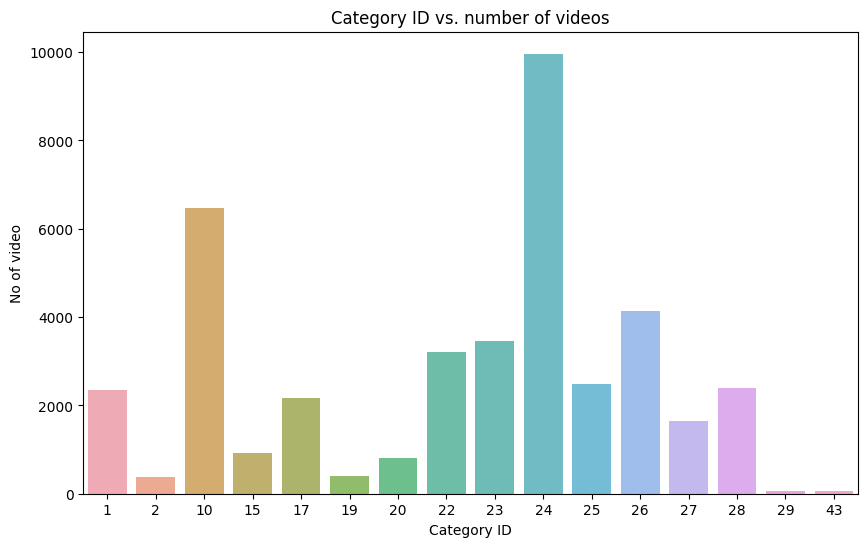

In [106]:
count = usVideos['category_id'].value_counts()
print(count)
plt.figure(figsize=(10,6))
sns.barplot(count.index, count.values, alpha=0.8)
plt.title("Category ID vs. number of videos")
plt.ylabel('No of video')
plt.xlabel("Category ID")
plt.show()

## Correlation Plot

In [107]:
usVideos.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'title_len',
       'channel_title_len', 'net_likes', 'trending_minute_differences',
       'description_len', 'tags_len', 'tags_cleaned'],
      dtype='object')

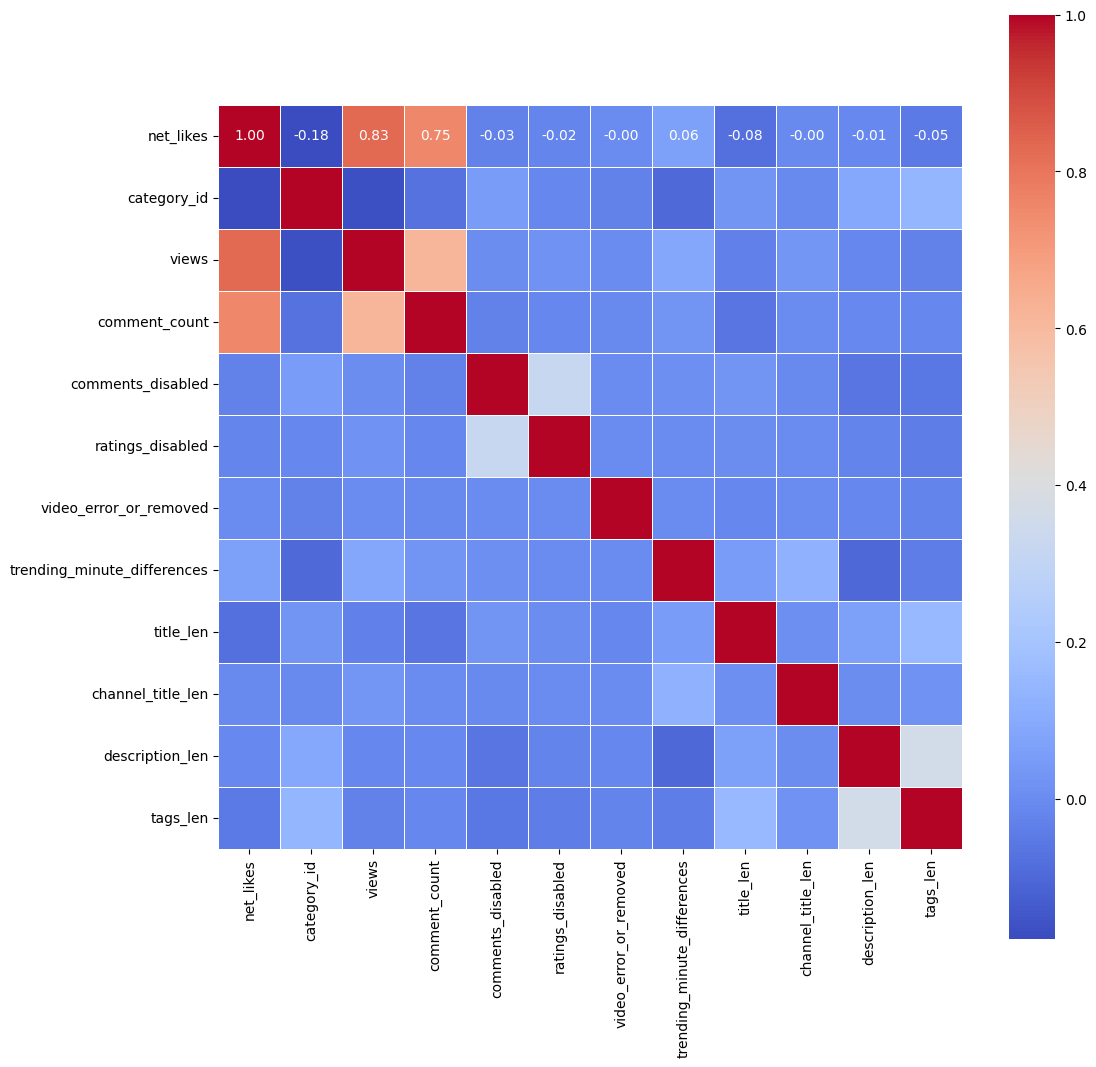

In [108]:
# 选择想要检查的feature，查看关联性
features = ['net_likes', 'category_id', 'views', 'comment_count', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'trending_minute_differences', 'title_len', 'channel_title_len',
       'description_len', 'tags_len']

# 计算相关性矩阵
corrmat = usVideos[features].corr()

# 绘制相关性矩阵热图
plt.figure(figsize=(12, 12))
sns.heatmap(corrmat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, square=True)

# 显示图形
plt.show()

# Model

In [109]:
X = usVideos[features[1:]]
y = usVideos["net_likes"]

# 分割数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Linear Regression

In [110]:
from sklearn.linear_model import LinearRegression

In [111]:
# 创建线性回归模型
lr = LinearRegression()

# 训练模型
lr.fit(X_train, y_train)

# 进行预测
y_pred_lr = lr.predict(X_test)

In [112]:
# 打印模型参数
print(f"Model Coefficients: {lr.coef_}")
print(f"Model intercept: {lr.intercept_}")

# 评估模型
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_lr))
print("Coefficient of Determination (R^2):", r2_score(y_test, y_pred_lr))

Model Coefficients: [-1.40821416e+03  1.72102166e-02  2.26671212e+00 -1.89426895e+04
 -7.97984104e+04 -2.40936877e+04  2.77426658e+00 -2.96268467e+02
 -7.33775279e+02  3.92846851e+00 -4.92818804e+02]
Model intercept: 67687.61737724596
Mean Squared Error: 9327086034.661905
Coefficient of Determination (R^2): 0.7850386176739528


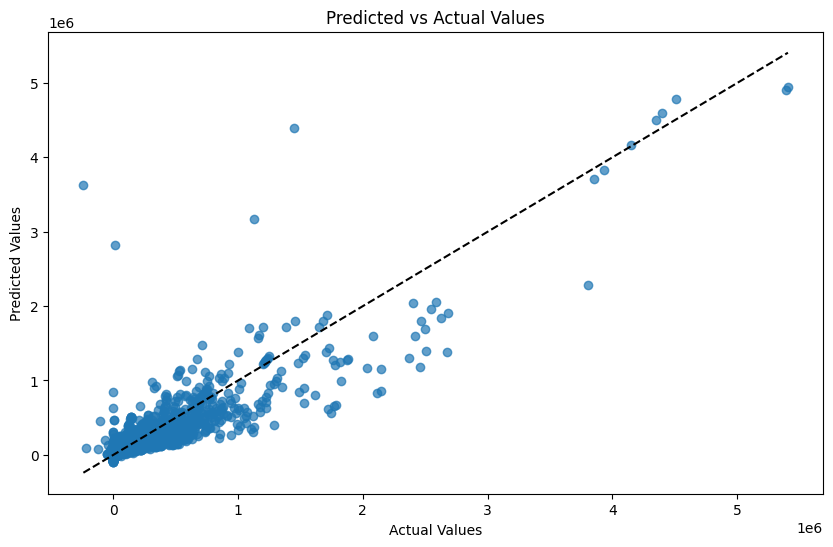

In [113]:
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# 绘制 y = x 线表示完美预测
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')

plt.show()

## Random Forest

In [114]:
from sklearn.ensemble import RandomForestRegressor

In [115]:
# 创建随机森林回归器实例
rfr = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rfr.fit(X_train, y_train)

# 对测试集进行预测
y_pred_rfr = rfr.predict(X_test)

# 评估模型
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rfr))
print("Coefficient of Determination (R^2):", r2_score(y_test, y_pred_rfr))

Mean Squared Error: 456656936.2336155
Coefficient of Determination (R^2): 0.9894754260980596


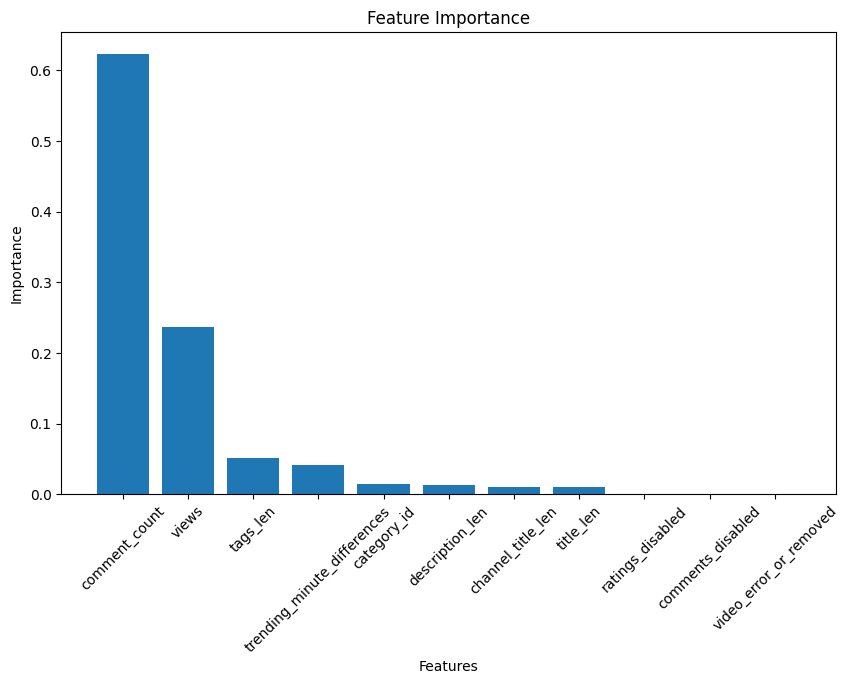

In [27]:
# 获取特征重要性
feature_importances = rfr.feature_importances_

# 创建特征重要性的DataFrame
importances = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})

# 绘制特征重要性
importances = importances.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(importances['feature'], importances['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

Find best parameters

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best HyperParameter:  {'max_depth': 20, 'n_estimators': 160}
0.9868827702056837


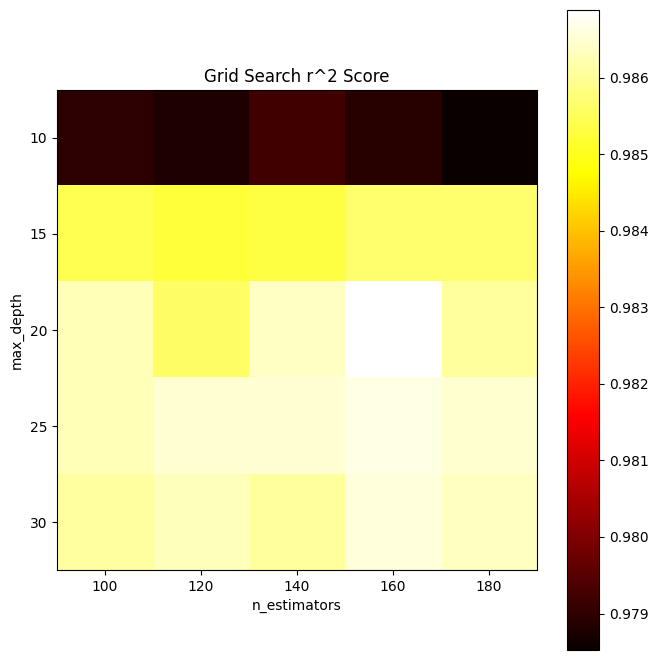

In [116]:
nEstimator = [100, 120, 140,160,180]
depth = [10,15,20,25,30]

RF = RandomForestRegressor()
hyperParam = [{'n_estimators':nEstimator,'max_depth': depth}]
gsv = GridSearchCV(RF,hyperParam,cv=5,verbose=1,scoring='r2',n_jobs=-1)
gsv.fit(X_train, y_train)
print("Best HyperParameter: ",gsv.best_params_)
print(gsv.best_score_)
scores = gsv.cv_results_['mean_test_score'].reshape(len(nEstimator),len(depth))
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
plt.colorbar()
plt.xticks(np.arange(len(nEstimator)), nEstimator)
plt.yticks(np.arange(len(depth)), depth)
plt.title('Grid Search r^2 Score')
plt.show()
maxDepth=gsv.best_params_['max_depth']
nEstimators=gsv.best_params_['n_estimators']

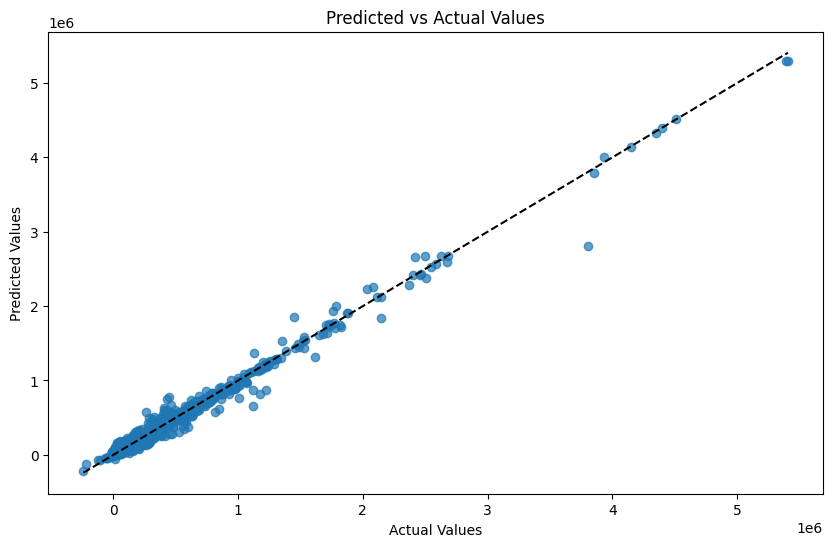

In [29]:
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rfr, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# 绘制 y = x 线表示完美预测
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')

plt.show()

## Sentiment Analysis

## TF-IDF on tags

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

In [59]:
# 步骤2: 应用TF-IDF转换
tfidf = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, preprocessor=lambda x: x)
tags_tfidf = tfidf.fit_transform(usVideos['tags_cleaned'])

In [71]:
# 步骤3: 独热编码category_id
ohe = OneHotEncoder()
category_ohe = ohe.fit_transform(usVideos[['category_id']])

In [65]:
usVideos.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'thumbnail_link', 'comments_disabled', 'ratings_disabled',
       'video_error_or_removed', 'description', 'net_likes',
       'trending_minute_differences', 'title_len', 'channel_title_len',
       'description_len', 'tags_len', 'tags_cleaned', 'tags_tfidf'],
      dtype='object')

In [74]:
num_features = usVideos[['views', 'comment_count', 'tags_len', 'trending_minute_differences', 'title_len', 'channel_title_len', 'description_len']]

In [75]:
# 检查各特征集的尺寸
print("tags_tfidf shape:", tags_tfidf.shape)
print("category_ohe shape:", category_ohe.shape)
print("num_features_sparse shape:", num_features.shape)

tags_tfidf shape: (40949, 56693)
category_ohe shape: (40949, 16)
num_features_sparse shape: (40949, 7)


In [76]:
# 步骤4: 合并所有特征
X2 = hstack([tags_tfidf, num_features, category_ohe])

In [78]:
# 划分训练集和测试集
X_train_2, X_test_2, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=42)

In [79]:
# 训练模型
rfr.fit(X_train_2, y_train)

# 对测试集进行预测
y_pred_rfr = rfr.predict(X_test_2)

# 评估模型
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_rfr))
print("Coefficient of Determination (R^2):", r2_score(y_test, y_pred_rfr))

Mean Squared Error: 370520608.65933675
Coefficient of Determination (R^2): 0.991460610321197


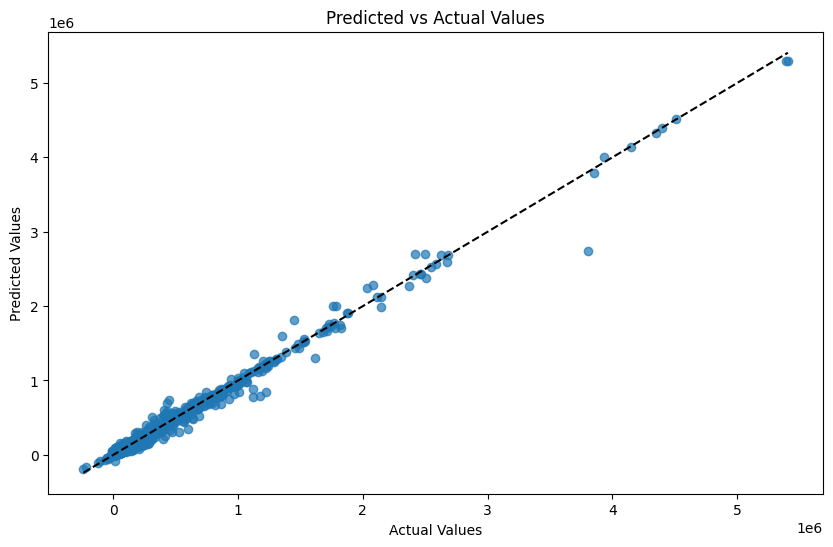

In [80]:
# 绘制散点图
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rfr, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')

# 绘制 y = x 线表示完美预测
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')

plt.show()